In [1]:
import torch, sys, os
print(sys.prefix)

/home/labsisfo/miniconda3/envs/vio-cw


# 1. Project Setup

## 1.1. Package Import

In [2]:
import os, csv, json, random, shutil
from dataclasses import dataclass
from typing import Optional

import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

import timm
from torchmetrics.classification import BinaryF1Score, BinaryAUROC
from sklearn.metrics import confusion_matrix

from torchvision import transforms
import random as pyrand

import io, random
import torchvision.transforms as T

import math, statistics
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

import glob

from sklearn.metrics import roc_curve, auc as sk_auc, precision_recall_curve, f1_score, confusion_matrix
import numpy as np

from collections import Counter

import uuid, socket, getpass, time, math
from datetime import datetime
from typing import Optional, Dict, Any, Tuple

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold

/home/labsisfo/miniconda3/envs/vio-cw/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True

Device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti


In [4]:
try:
    from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
except Exception as e:
    raise RuntimeError("Install: pip install scikit-learn") from e

## 1.2. Configurations

In [5]:
@dataclass
class TrainConfig:
    train_csv: str = "data/splits/train.csv"
    val_csv:   str = "data/splits/val.csv"
    test_csv:  str = "data/splits/test.csv"
    img_size:  int = 320
    robust_aug: bool = True

    batch_size: int = 32
    num_workers: int = 4
    use_class_weight: bool = True
    use_weighted_sampler: bool = False

    epochs: int = 400
    lr: float = 3e-4
    weight_decay: float = 1e-4
    early_stop_patience: int = 15
    seed: int = 42
    amp: bool = True

    model_name: str = "efficientnetv2_l"
    num_classes: int = 2

    use_distill: bool = False
    teacher_ckpt: str = "models/server/best_server.pt"
    distill_alpha: float = 0.5
    distill_T: float = 6.0

    out_dir: str = "experiments/runs/student_cv_no_distill"
    save_best_name: str = "best_model.pt"

cfg = TrainConfig()

## 1.3. Reproducibility

In [6]:
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(cfg.seed)

# 2. Dataset

## 2.1. Data Initialization

In [7]:
class CSVDataset(Dataset):
    def __init__(self, csv_path: str, transform=None):
        self.samples = []
        with open(csv_path, "r", newline="") as f:
            reader = csv.reader(f)
            header = next(reader)
            if header and header[0].lower() != "path":  # no header case
                f.seek(0); reader = csv.reader(f)
            for row in reader:
                if len(row) >= 2:
                    p, y = row[0], int(row[1])
                    self.samples.append((p, y))
        self.transform = transform

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        p, y = self.samples[idx]
        img = Image.open(p).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, torch.tensor(y, dtype=torch.long)

In [8]:
def load_csv(path: str):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV tidak ditemukan: {path}")
    rows = []
    with open(path, "r", newline="") as f:
        rd = csv.reader(f)
        header = next(rd, None)
        # Jika kolom pertama bukan "path", berarti tidak ada header -> ulang dari awal
        if header and str(header[0]).lower() != "path":
            f.seek(0)
            rd = csv.reader(f)
        for r in rd:
            if not r: 
                continue
            p = r[0]
            y = int(r[1]) if len(r) > 1 and r[1] != "" else 0
            rows.append((p, y))
    return rows


In [9]:
train_csv = "data/splits/train.csv"
val_csv   = "data/splits/val.csv"
test_csv  = "data/splits/test.csv"

train = load_csv(train_csv)
val   = load_csv(val_csv)
test  = load_csv(test_csv)

splits = {"train": train, "val": val, "test": test}

## 2.3. Data Preprocessing

In [10]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [11]:
def safe_open_rgb(path):
    img = Image.open(path)
    if img.mode in ("RGBA", "LA", "P"):
        img = img.convert("RGBA")
        bg = Image.new("RGB", img.size, (0, 0, 0))
        bg.paste(img, mask=img.split()[-1])
        img = bg
    elif img.mode != "RGB":
        img = img.convert("RGB")
    return img

In [12]:
old_getitem = CSVDataset.__getitem__
def _patched_getitem(self, idx):
    p, y = self.samples[idx]
    try:
        img = safe_open_rgb(p)
    except Exception as e:
        from PIL import Image
        img = Image.new("RGB", (cfg.img_size, cfg.img_size), (0,0,0))
    if self.transform:
        img = self.transform(img)
    import torch
    return img, torch.tensor(y, dtype=torch.long)

CSVDataset.__getitem__ = _patched_getitem

In [13]:
class RandomJpegArtifacts(torch.nn.Module):
    """
    Simulate JPEG compression artifacts in-memory (no disk I/O).
    p: probability to apply
    q_range: (min_quality, max_quality)
    """
    def __init__(self, p=0.3, q_range=(40, 70)):
        super().__init__()
        self.p = p
        self.q_range = q_range

    def forward(self, img):
        if random.random() > self.p:
            return img
        buf = io.BytesIO()
        q = random.randint(*self.q_range)
        img.save(buf, format="JPEG", quality=q, optimize=False)  # artifacts
        buf.seek(0)
        comp = Image.open(buf)
        if comp.mode != "RGB":
            comp = comp.convert("RGB")
        return comp

In [14]:
class RandomLowLight(torch.nn.Module):
    """
    Random low-light via simple gamma-like reduction on value.
    """
    def __init__(self, p=0.3, scale_range=(0.6, 0.9)):
        super().__init__()
        self.p = p
        self.scale_range = scale_range

    def forward(self, img):
        if random.random() > self.p:
            return img
        s = random.uniform(*self.scale_range)
        return img.point(lambda v: int(v * s))

In [15]:
def build_transforms(img_size=320, robust_aug=True):
    train_list = [
        T.Resize((img_size, img_size)),
        T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(brightness=0.2, contrast=0.2),
    ]
    if robust_aug:
        train_list += [
            RandomLowLight(p=0.3, scale_range=(0.6, 0.9)),
            RandomJpegArtifacts(p=0.3, q_range=(40, 70)),
        ]
    train_list += [T.ToTensor(), T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]

    val_tf = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    return T.Compose(train_list), val_tf

train_tf, val_tf = build_transforms(cfg.img_size, cfg.robust_aug)

In [16]:
cfg.num_workers = 2

In [17]:
train_ds = CSVDataset(cfg.train_csv, transform=train_tf)
val_ds   = CSVDataset(cfg.val_csv,   transform=val_tf)
test_ds  = CSVDataset(cfg.test_csv,  transform=val_tf)

In [18]:
train_sampler = None
if cfg.use_weighted_sampler:
    labels = [y for _, y in train_ds.samples]
    import numpy as np
    class_count = np.bincount(labels, minlength=2)
    class_weight = 1.0 / np.maximum(class_count, 1)
    sample_weight = [class_weight[y] for y in labels]
    train_sampler = WeightedRandomSampler(sample_weight, num_samples=len(sample_weight), replacement=True)

## 2.4. Data Loading

In [19]:
train_dl = DataLoader(train_ds, batch_size=cfg.batch_size,
                      shuffle=(train_sampler is None), sampler=train_sampler,
                      num_workers=cfg.num_workers, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False,
                      num_workers=cfg.num_workers, pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False,
                      num_workers=cfg.num_workers, pin_memory=True)
print("Rebuilt loaders with num_workers =", cfg.num_workers)

Rebuilt loaders with num_workers = 2


In [20]:
def channel_stats_after_transform(rows, transform, k=256):
    import numpy as np
    ps = [p for p,_ in rows]
    sample = ps if len(ps)<=k else np.random.choice(ps, k, replace=False)
    xs=[]
    for p in sample:
        with Image.open(p) as im:
            im = im.convert("RGB")
            xs.append(transform(im))
    X = torch.stack(xs)  # [N,3,H,W]
    mean = X.mean(dim=(0,2,3)).cpu().numpy()
    std  = X.std(dim=(0,2,3)).cpu().numpy()
    return mean, std

In [21]:
mean_tr, std_tr = channel_stats_after_transform(splits["train"], train_tf, k=256)
mean_va, std_va = channel_stats_after_transform(splits["val"],   val_tf,   k=256)
print("Train tensor mean/std:", mean_tr, std_tr)
print("Val   tensor mean/std:", mean_va, std_va)

/home/labsisfo/miniconda3/envs/vio-cw/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train tensor mean/std: [ 0.1465757  -0.04446741  0.0505291 ] [1.3325001 1.3861123 1.3848997]
Val   tensor mean/std: [0.47585347 0.236899   0.3582972 ] [1.4827062 1.562989  1.5922033]


In [22]:
class RowsDataset(Dataset):
    def __init__(self, rows, transform):
        self.rows = rows
        self.transform = transform
    def __len__(self):
        return len(self.rows)
    def __getitem__(self, i):
        p, y = self.rows[i]
        im = Image.open(p).convert("RGB")
        x = self.transform(im) if self.transform else im
        return x, torch.tensor(y, dtype=torch.long)


In [23]:
def compute_class_weight_from_rows(rows, num_classes=2, min_count_eps=1e-6):
    """
    rows: list of (path, label)
    return: torch.FloatTensor shape [num_classes]
    """
    counts = Counter([lbl for _, lbl in rows])
    # pastikan semua kelas ada
    weights = []
    total = sum(counts.values())
    for c in range(num_classes):
        cnt = counts.get(c, 0)
        # skema umum: weight_c = total / (num_classes * count_c)
        w = total / (max(cnt, min_count_eps) * num_classes)
        weights.append(w)
    w = torch.tensor(weights, dtype=torch.float32)
    return w

# 3. Model

## 3.1. Model Factory

In [24]:
def create_model(name: str, num_classes: int = 2, pretrained: bool = True):
    alias = {
        "efficientnetv2_l": "tf_efficientnetv2_l",
    }
    name = alias.get(name, name)
    return timm.create_model(name, pretrained=pretrained, num_classes=num_classes)

In [25]:
@torch.inference_mode()
def measure_latency_ms_per_image(model, img_size=224, device=None, batch_size=1,
                                 warmup=20, iters=100, amp=True):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)
    x = torch.randn(batch_size, 3, img_size, img_size, device=device)
    if device == "cuda":
        torch.cuda.synchronize()
    for _ in range(warmup):
        with torch.amp.autocast('cuda', enabled=(amp and device=="cuda")):
            _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    for _ in range(iters):
        with torch.amp.autocast('cuda', enabled=(amp and device=="cuda")):
            _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()
    t1 = time.perf_counter()
    total_ms = (t1 - t0) * 1000.0
    ms_per_batch = total_ms / iters
    ms_per_img   = ms_per_batch / batch_size
    ips          = 1000.0 / ms_per_img
    return ms_per_img, ips

## 3.2. Distillation

In [26]:
class DistillLoss(nn.Module):
    """
    total = alpha * CrossEntropy(student_logits, y_true)
          + (1-alpha) * KL(softmax(student/T) || softmax(teacher/T)) * T^2
    """
    def __init__(self, alpha=0.5, T=2.0, ce_weight=None):
        super().__init__()
        self.alpha = alpha
        self.T = T
        # <-- pakai class weight jika diberikan
        self.ce = nn.CrossEntropyLoss(weight=ce_weight)

    def forward(self, s_logits, y_true, t_logits=None):
        ce = self.ce(s_logits, y_true)
        if t_logits is None:
            return ce
        log_p_s = F.log_softmax(s_logits / self.T, dim=1)
        p_t     = F.softmax(t_logits / self.T, dim=1)
        kd = F.kl_div(log_p_s, p_t, reduction="batchmean") * (self.T**2)
        return self.alpha * ce + (1 - self.alpha) * kd


In [27]:
def run_one_epoch(model, dl, optimizer=None, scaler=None, criterion=None, teacher=None, kd: Optional[DistillLoss]=None):
    training = optimizer is not None
    model.train(training)

    loss_sum = 0.0
    f1 = BinaryF1Score().to(device)
    auc = BinaryAUROC().to(device)

    for x, y in dl:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)

        if training:
            optimizer.zero_grad(set_to_none=True)
            with torch.no_grad():
                t_logits = teacher(x) if (teacher is not None) else None
            with torch.amp.autocast('cuda', enabled=(scaler is not None)):
                s_logits = model(x)
                loss = (kd(s_logits, y, t_logits) if kd is not None else criterion(s_logits, y))
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad():
                s_logits = model(x)
                loss = (kd(s_logits, y, teacher(x)) if (kd and teacher) else criterion(s_logits, y))

        p = torch.softmax(s_logits, dim=1)[:,1]
        f1.update(p, y.bool()); auc.update(p, y.bool())
        loss_sum += loss.item() * x.size(0)

    n = len(dl.dataset)
    return loss_sum/n, f1.compute().item(), auc.compute().item()

## 3.3. Train Loop & Early Stopping

In [28]:
def compute_class_weight_from_ds(ds: CSVDataset):
    labels = [y for _, y in ds.samples]
    counts = np.bincount(labels, minlength=2)
    total  = counts.sum()
    weights = total / (2.0 * np.maximum(counts, 1))
    return torch.tensor(weights, dtype=torch.float32).to(device), counts

In [29]:
# def train_model_with_loaders(cfg: TrainConfig, train_dl_local, val_dl_local, verbose: int = 1, log_csv: bool = False):
#     os.makedirs(cfg.out_dir, exist_ok=True)
#     set_seed(cfg.seed)

#     model = create_model(cfg.model_name, cfg.num_classes).to(device)

#     try:
#         train_rows_src = getattr(train_dl_local.dataset, 'rows', None)
#     except Exception:
#         train_rows_src = None

#     cw = None
#     if train_rows_src is not None:
#         cw = compute_class_weight_from_rows(train_rows_src, num_classes=cfg.num_classes).to(device)
#         if verbose:
#             from collections import Counter
#             cnt = Counter([lbl for _, lbl in train_rows_src])
#             # print(f"class counts: {dict(cnt)} | class weights: {cw.tolist()}")

#     teacher = None
#     kd_loss = None
#     if cfg.use_distill:
#         assert os.path.exists(cfg.teacher_ckpt), f"Teacher ckpt not found: {cfg.teacher_ckpt}"
#         teacher = create_model("efficientnetv2_l", cfg.num_classes).to(device)
#         teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))
#         teacher.eval()
#         for p in teacher.parameters():
#             p.requires_grad = False
#         kd_loss = DistillLoss(alpha=cfg.distill_alpha, T=cfg.distill_T, ce_weight=cw)

#     criterion = nn.CrossEntropyLoss(weight=cw)

#     optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
#     scaler = torch.amp.GradScaler('cuda', enabled=cfg.amp)

#     best_auc, bad = -1.0, 0
#     best_path = os.path.join(cfg.out_dir, cfg.save_best_name)

#     if log_csv:
#         import csv
#         with open(os.path.join(cfg.out_dir, "train_log.csv"), "w", newline="") as f:
#             csv.writer(f).writerow(["epoch","tr_loss","tr_f1","tr_auc","va_loss","va_f1","va_auc"])

#     for epoch in range(1, cfg.epochs + 1):
#         tr_loss, tr_f1, tr_auc = run_one_epoch(
#             model, train_dl_local, optimizer, scaler, criterion, teacher, kd_loss
#         )
#         va_loss, va_f1, va_auc = run_one_epoch(
#             model, val_dl_local, None, None, criterion, teacher, kd_loss
#         )

#         # if verbose:
#         #     print(f"[{epoch:02d}/{cfg.epochs}] "
#         #           f"train: loss={tr_loss:.4f} f1={tr_f1:.3f} auc={tr_auc:.3f} | "
#         #           f"val: loss={va_loss:.4f} f1={va_f1:.3f} auc={va_auc:.3f}")

#         if log_csv:
#             with open(os.path.join(cfg.out_dir, "train_log.csv"), "a", newline="") as f:
#                 import csv
#                 csv.writer(f).writerow([epoch, tr_loss, tr_f1, tr_auc, va_loss, va_f1, va_auc])

#         # early stopping by val AUC
#         if va_auc > best_auc:
#             best_auc, bad = va_auc, 0
#             torch.save(model.state_dict(), best_path)
#         else:
#             bad += 1
#             if bad >= cfg.early_stop_patience:
#                 if verbose:
#                     print("Early stopping triggered.")
#                 break

#     if verbose:
#         print("Best val AUC:", round(best_auc, 4), "| saved:", best_path)
#     return best_path, best_auc


# EARLY STOP F1
def train_model_with_loaders(cfg: TrainConfig, train_dl_local, val_dl_local, verbose: int = 1, log_csv: bool = False):
    os.makedirs(cfg.out_dir, exist_ok=True)
    set_seed(cfg.seed)

    model = create_model(cfg.model_name, cfg.num_classes).to(device)

    try:
        train_rows_src = getattr(train_dl_local.dataset, 'rows', None)
    except Exception:
        train_rows_src = None

    cw = None
    if train_rows_src is not None:
        cw = compute_class_weight_from_rows(train_rows_src, num_classes=cfg.num_classes).to(device)
        if verbose:
            from collections import Counter
            cnt = Counter([lbl for _, lbl in train_rows_src])
            print(f"class counts: {dict(cnt)} | class weights: {cw.tolist()}")

    teacher = None
    kd_loss = None
    if cfg.use_distill:
        assert os.path.exists(cfg.teacher_ckpt), f"Teacher ckpt not found: {cfg.teacher_ckpt}"
        teacher = create_model("efficientnetv2_l", cfg.num_classes).to(device)
        teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))
        teacher.eval()
        for p in teacher.parameters():
            p.requires_grad = False
        kd_loss = DistillLoss(alpha=cfg.distill_alpha, T=cfg.distill_T, ce_weight=cw)

    criterion = nn.CrossEntropyLoss(weight=cw)

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scaler = torch.amp.GradScaler('cuda', enabled=cfg.amp)

    # track best F1 instead of best AUC
    best_f1, bad = -1.0, 0
    best_path = os.path.join(cfg.out_dir, cfg.save_best_name)

    if log_csv:
        import csv
        with open(os.path.join(cfg.out_dir, "train_log.csv"), "w", newline="") as f:
            csv.writer(f).writerow(["epoch","tr_loss","tr_f1","tr_auc","va_loss","va_f1","va_auc"])

    for epoch in range(1, cfg.epochs + 1):
        tr_loss, tr_f1, tr_auc = run_one_epoch(
            model, train_dl_local, optimizer, scaler, criterion, teacher, kd_loss
        )
        va_loss, va_f1, va_auc = run_one_epoch(
            model, val_dl_local, None, None, criterion, teacher, kd_loss
        )

        if verbose:
            print(f"[{epoch:02d}/{cfg.epochs}] "
                  f"train: loss={tr_loss:.4f} f1={tr_f1:.3f} auc={tr_auc:.3f} | "
                  f"val: loss={va_loss:.4f} f1={va_f1:.3f} auc={va_auc:.3f}")

        if log_csv:
            with open(os.path.join(cfg.out_dir, "train_log.csv"), "a", newline="") as f:
                import csv
                csv.writer(f).writerow([epoch, tr_loss, tr_f1, tr_auc, va_loss, va_f1, va_auc])

        # early stopping by val F1 (bukan AUC lagi)
        if va_f1 > best_f1:
            best_f1, bad = va_f1, 0
            torch.save(model.state_dict(), best_path)
        else:
            bad += 1
            # if bad >= cfg.early_stop_patience:
            #     if verbose:
            #         print("Early stopping triggered.")
            #     break

    if verbose:
        print("Best val F1:", round(best_f1, 4), "| saved:", best_path)
    return best_path, best_f1


In [30]:
def select_student_via_cv(student_candidates, k=5, seed=42):
    all_rows = splits["train"] + splits["val"]
    X = [p for p,_ in all_rows]
    y = np.array([lbl for _,lbl in all_rows])
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    results = []
    perfold = {}

    for name, img_sz, bs in student_candidates:
        fold_metrics = []
        perfold[name] = []

        for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
            train_rows = [all_rows[i] for i in tr_idx]
            val_rows   = [all_rows[i] for i in va_idx]
            train_tf, val_tf = build_transforms(img_sz, cfg.robust_aug)

            ds_tr = RowsDataset(train_rows, train_tf)
            ds_va = RowsDataset(val_rows,   val_tf)
            dl_tr = DataLoader(ds_tr, batch_size=bs, shuffle=True,  num_workers=cfg.num_workers, pin_memory=True)
            dl_va = DataLoader(ds_va, batch_size=bs, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)

            tr_counts = Counter([lbl for _, lbl in train_rows])
            va_counts = Counter([lbl for _, lbl in val_rows])
            
            tr_total = len(train_rows); va_total = len(val_rows)
            tr_pos = tr_counts.get(1, 0); tr_neg = tr_counts.get(0, 0)
            va_pos = va_counts.get(1, 0); va_neg = va_counts.get(0, 0)
            
            def _ratio(pos, total): 
                return (pos / total) if total else 0.0
            
            print(
                f"[{name}] Fold {fold}/{k} | "
                f"TRAIN: n={tr_total} (neg={tr_neg}, pos={tr_pos}, pos_ratio={_ratio(tr_pos,tr_total):.3f}) | "
                f"VAL: n={va_total} (neg={va_neg}, pos={va_pos}, pos_ratio={_ratio(va_pos,va_total):.3f}) | "
                f"batches: train={len(dl_tr)}, val={len(dl_va)}"
            )

            out_dir = f"experiments/runs/cv_{k}/student_{name.replace('.','_')}/fold_{fold}"
            cfg_student = TrainConfig(
                model_name=name, out_dir=out_dir, save_best_name="best_student.pt",
                use_distill=False, teacher_ckpt=cfg.teacher_ckpt,
                distill_alpha=cfg.distill_alpha, distill_T=cfg.distill_T,
                img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
                use_class_weight=True, use_weighted_sampler=False
            )
            best_path, _ = train_model_with_loaders(cfg_student, dl_tr, dl_va, verbose=0, log_csv=True)

            model = create_model(name, 2).to(device)
            model.load_state_dict(torch.load(best_path, map_location=device)); model.eval()
            ce = nn.CrossEntropyLoss()
            va_loss, va_f1, va_auc = run_one_epoch(model, dl_va, optimizer=None, scaler=None, criterion=ce)

            fold_metrics.append((va_auc, va_f1))
            perfold[name].append({"fold": fold, "val_auc": float(va_auc), "val_f1": float(va_f1)})

        mean_auc = float(np.mean([a for a,_ in fold_metrics]))
        mean_f1  = float(np.mean([f for _,f in fold_metrics]))
        print(f"[CV] {name}: mean AUC={mean_auc:.3f} | mean F1={mean_f1:.3f}")
        results.append((name, mean_auc, mean_f1))

    results.sort(key=lambda t: (t[1], t[2]), reverse=True)
    best_name = results[0][0]
    return best_name, results, perfold

## 3.4. Temperature scaling

In [31]:
class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1)*1.0)
    def forward(self, x):
        return self.model(x) / self.temperature.clamp(0.5, 5.0)

## 3.5. Testing Evaluation

In [32]:
def quick_test_eval(ckpt_path: str, model_name: str, dl):
    model = create_model(model_name, 2).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()
    ce = nn.CrossEntropyLoss()

    loss, f1, auc = run_one_epoch(model, dl, optimizer=None, scaler=None, criterion=ce)
    print(f"[TEST] loss={loss:.4f}  F1={f1:.3f}  AUC={auc:.3f}")

    y_prob, y_true = [], []
    with torch.no_grad():
        for x, y in dl:
            x = x.to(device)
            p = torch.softmax(model(x), dim=1)[:,1].detach().cpu().numpy()
            y_prob.append(p); y_true.append(y.numpy())
    y_prob = np.concatenate(y_prob); y_true = np.concatenate(y_true)
    y_hat  = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_hat, labels=[0,1])
    print("Confusion Matrix (thr=0.5)\n[[TN FP]\n [FN TP]]\n", cm)
    return loss, f1, auc, cm

## 3.6. Training

### 3.6.2. Student Model

In [33]:
import warnings
warnings.filterwarnings("ignore", message="Palette images with Transparency expressed in bytes should be converted to RGBA images")
# warnings.filterwarnings("ignore", message="FutureWarning: You are using `torch.load` with `weights_only=False`")

In [34]:
[m for m in timm.list_models(pretrained=True) if "mobilenetv3" in m or "efficientnet_lite" in m][:20]

['efficientnet_lite0.ra_in1k',
 'mobilenetv3_large_100.miil_in21k',
 'mobilenetv3_large_100.miil_in21k_ft_in1k',
 'mobilenetv3_large_100.ra_in1k',
 'mobilenetv3_rw.rmsp_in1k',
 'mobilenetv3_small_050.lamb_in1k',
 'mobilenetv3_small_075.lamb_in1k',
 'mobilenetv3_small_100.lamb_in1k',
 'tf_efficientnet_lite0.in1k',
 'tf_efficientnet_lite1.in1k',
 'tf_efficientnet_lite2.in1k',
 'tf_efficientnet_lite3.in1k',
 'tf_efficientnet_lite4.in1k',
 'tf_mobilenetv3_large_075.in1k',
 'tf_mobilenetv3_large_100.in1k',
 'tf_mobilenetv3_large_minimal_100.in1k',
 'tf_mobilenetv3_small_075.in1k',
 'tf_mobilenetv3_small_100.in1k',
 'tf_mobilenetv3_small_minimal_100.in1k']

In [35]:
student_candidates = [
    ("tf_mobilenetv3_small_100.in1k",     224, 96)
]

In [36]:
KD_RUNS_DIR = "experiments/runs/kd_alpha"
os.makedirs(KD_RUNS_DIR, exist_ok=True)

def kd_outdir(a: float) -> str:
    return os.path.join(KD_RUNS_DIR, f"alpha_{a:.1f}".replace(".", "_"))

In [37]:
def plot_run_curves(run_dir, title=None):
    csv_path = os.path.join(run_dir, "train_log.csv")
    if not os.path.exists(csv_path):
        print("missing:", csv_path); return
    df = pd.read_csv(csv_path)
    fig,ax = plt.subplots(1,3,figsize=(12,3))
    ax[0].plot(df.epoch, df.tr_loss, label="train"); ax[0].plot(df.epoch, df.va_loss, label="val")
    ax[0].set_title("Loss"); ax[0].legend()
    ax[1].plot(df.epoch, df.tr_f1, label="train"); ax[1].plot(df.epoch, df.va_f1, label="val")
    ax[1].set_title("F1")
    ax[2].plot(df.epoch, df.tr_auc, label="train"); ax[2].plot(df.epoch, df.va_auc, label="val")
    ax[2].set_title("AUC")
    if title: fig.suptitle(title)
    plt.show()

In [38]:
def plot_kd_val_curves(kd_root, metrics=("va_loss","va_f1","va_auc"), title="Knowledge Distillation"):
    paths = sorted(glob.glob(os.path.join(kd_root, "alpha_*", "train_log.csv")))
    if not paths:
        print("Belum ada log KD di", kd_root)
        return

    alphas, csvs = [], []
    for p in paths:
        folder = os.path.basename(os.path.dirname(p))
        a_str = folder.split("alpha_")[-1].replace("_", ".")
        try:
            alphas.append(float(a_str)); csvs.append(p)
        except:
            pass

    order = np.argsort(alphas)
    alphas = [alphas[i] for i in order]
    csvs   = [csvs[i]   for i in order]

    a_min, a_max = min(alphas), max(alphas)
    def color_for(a):
        t = (a - a_min) / (a_max - a_min + 1e-9)
        return plt.cm.Greys(t)

    fig, axes = plt.subplots(1, len(metrics), figsize=(6*len(metrics), 6), sharex=True, constrained_layout=True)
    if len(metrics) == 1:
        axes = [axes]
    for ax in axes:
        try:
            ax.set_box_aspect(1.0)
        except Exception:
            pass

    for a, csv_path in zip(alphas, csvs):
        df = pd.read_csv(csv_path)
        for ax, m in zip(axes, metrics):
            ax.plot(df["epoch"], df[m], label=f"α={a:.1f}", linewidth=1.8, color=color_for(a))

    name_map = {"va_loss":"Validation Loss", "va_f1":"Validation F1", "va_auc":"Validation AUC"}
    for ax, m in zip(axes, metrics):
        ax.set_xlabel("Epoch")
        ax.set_ylabel(name_map.get(m, m))
        ax.grid(True, alpha=0.3)

    labels_to_handles = {}
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        for hh, ll in zip(h, l):
            if ll not in labels_to_handles:
                labels_to_handles[ll] = hh
        leg = ax.get_legend()
        if leg:
            leg.remove()

    fig.suptitle(title, y=1.02)
    fig.legend(list(labels_to_handles.values()), list(labels_to_handles.keys()),
               loc="upper center", ncol=min(6, len(labels_to_handles)),
               frameon=False, bbox_to_anchor=(0.5, 1.10))
    plt.show()

In [39]:
# # best_name, cv_table, cv_perfold = select_student_via_cv(student_candidates, k=5, seed=cfg.seed)
# # print("Best via CV:", best_name)

# # cand = [(n, sz, bs) for (n, sz, bs) in student_candidates]

# # lat_rows = []
# # for name, img_sz, bs in cand:
# #     m = create_model(name, 2, pretrained=True).to(device).eval()
# #     ms1, ips1 = measure_latency_ms_per_image(m, img_size=img_sz, device=device, batch_size=1, warmup=30, iters=120, amp=True)
# #     ms8, ips8 = measure_latency_ms_per_image(m, img_size=img_sz, device=device, batch_size=8, warmup=20, iters=80, amp=True)
# #     lat_rows.append({
# #         "model": name,
# #         "img_size": img_sz,
# #         "latency_ms_1x": float(ms1),
# #         "ips_1x": float(ips1),
# #         "latency_ms_8x": float(ms8),
# #         "ips_8x": float(ips8),
# #     })

# # df_latency = pd.DataFrame(lat_rows)
# # df_latency

# # print("\n== CV Summary (mean over folds) ==")
# # print(f"{'model':30s}  {'mean_auc':>8s}  {'mean_f1':>8s}")
# # for name, mean_auc, mean_f1 in cv_table:
# #     print(f"{name:30s}  {mean_auc:8.4f}  {mean_f1:8.4f}")

# # print("\n== Per-fold scores ==")
# # for name in cv_perfold:
# #     rows = cv_perfold[name]
# #     aucs = ", ".join(f"{r['val_auc']:.4f}" for r in rows)
# #     f1s  = ", ".join(f"{r['val_f1']:.4f}" for r in rows)
# #     print(f"{name:30s} | AUC: [{aucs}] | F1: [{f1s}]")

# # df_summary = pd.DataFrame(cv_table, columns=["model","mean_auc","mean_f1"]).sort_values("mean_auc", ascending=False)
# # display(df_summary)

# # score_kd = df_summary.merge(df_latency, on="model", how="left")

# # AUC_EPS = 0.005
# # auc_max = score_kd["mean_auc"].max()
# # candidates_eps = score_kd[score_kd["mean_auc"] >= auc_max - AUC_EPS]
# # picked_pareto = candidates_eps.sort_values(["latency_ms_1x","mean_f1"], ascending=[True, False]).iloc[0]

# # def minmax(s): return (s - s.min()) / (s.max() - s.min() + 1e-9)
# # norm_auc = minmax(score_kd["mean_auc"])
# # norm_lat = minmax(score_kd["latency_ms_1x"])
# # ALPHA = 0.7
# # score_kd["composite"] = ALPHA*norm_auc + (1-ALPHA)*(1 - norm_lat)
# # picked_comp = score_kd.sort_values(["composite","mean_f1"], ascending=[False, False]).iloc[0]

# # print("\nBest via AUC+Latency:", picked_pareto["model"])
# # best_name = picked_pareto["model"]  # ganti model terbaik hasil CV biasa
# # display(score_kd)

# # plt.figure(figsize=(4,3))
# # plt.scatter(score_kd["latency_ms_1x"], score_kd["mean_auc"], s=80)
# # for i,row in score_kd.iterrows():
# #     plt.text(row["latency_ms_1x"]*1.02, row["mean_auc"], row["model"], fontsize=8)
# # plt.xlabel("Latency per image (ms)")
# # plt.ylabel("Mean AUC (CV)")
# # plt.title("Accuracy–Latency Trade-off")
# # plt.grid(True, alpha=0.3)
# # plt.show()

# # os.makedirs("experiments/summary", exist_ok=True)
# # score_kd.sort_values(["mean_auc","latency_ms_1x"], ascending=[False, True]).to_csv(
# #     "experiments/summary/student_cv_latency.csv", index=False
# # )
# # print("Saved summary with latency ranking ✓")

# # rows = []
# # for name, items in cv_perfold.items():
# #     for it in items:
# #         rows.append({"model": name, "fold": it["fold"], "val_auc": it["val_auc"], "val_f1": it["val_f1"]})
# # df_perfold = pd.DataFrame(rows).sort_values(["model","fold"])
# # display(df_perfold)

# # import glob

# # base_dir = "experiments/runs/cv_5"
# # students = [d for d in os.listdir(base_dir) if d.startswith("student_")]

# # for stu in students:
# #     model_name = stu.replace("student_", "")
# #     fold_paths = sorted(glob.glob(os.path.join(base_dir, stu, "fold_*", "train_log.csv")))
# #     if not fold_paths:
# #         continue

# #     plt.figure(figsize=(4, 3))
# #     for csv_path in fold_paths:
# #         fold_id = int(csv_path.split("fold_")[-1].split("/")[0])
# #         df = pd.read_csv(csv_path)
# #         plt.plot(df["epoch"], df["va_auc"], label=f"Fold {fold_id} AUC", linewidth=1.6)
# #     plt.title(f"{model_name} – Validation AUC per Fold")
# #     plt.xlabel("Epoch")
# #     plt.ylabel("Validation AUC")
# #     plt.legend()
# #     plt.grid(True, alpha=0.3)
# #     plt.tight_layout()
# #     plt.show()

# #     plt.figure(figsize=(4, 3))
# #     for csv_path in fold_paths:
# #         fold_id = int(csv_path.split("fold_")[-1].split("/")[0])
# #         df = pd.read_csv(csv_path)
# #         plt.plot(df["epoch"], df["va_f1"], label=f"Fold {fold_id} F1", linewidth=1.6)
# #     plt.title(f"{model_name} – Validation F1 per Fold")
# #     plt.xlabel("Epoch")
# #     plt.ylabel("Validation F1")
# #     plt.legend()
# #     plt.grid(True, alpha=0.3)
# #     plt.tight_layout()
# #     plt.show()

# # full_rows = splits["train"] + splits["val"]
# # img_sz = next(sz for (n, sz, _bs) in student_candidates if n == best_name)
# # bs     = next(b  for (n, _sz, b) in student_candidates if n == best_name)
# # train_tf_full, val_tf_full = build_transforms(img_sz, cfg.robust_aug)

# # ds_full = RowsDataset(full_rows, train_tf_full)
# # dl_full = DataLoader(ds_full, batch_size=bs, shuffle=True,
# #                      num_workers=cfg.num_workers, pin_memory=True)

# # ds_val_student = RowsDataset(splits["val"], val_tf_full)
# # val_dl_student = DataLoader(ds_val_student, batch_size=bs, shuffle=False,
# #                             num_workers=cfg.num_workers, pin_memory=True)

# # full_rows = splits["train"] + splits["val"]
# # img_sz = next(sz for (n, sz, _bs) in student_candidates if n == "tf_efficientnet_lite0.in1k")
# # bs     = next(b  for (n, _sz, b) in student_candidates if n == "tf_efficientnet_lite0.in1k")
# # train_tf_full, val_tf_full = build_transforms(img_sz, cfg.robust_aug)

# full_rows = splits["train"] + splits["val"]
# img_sz = next(sz for (n, sz, _bs) in student_candidates if n == "tf_mobilenetv3_large_100.in1k")
# bs     = next(b  for (n, _sz, b) in student_candidates if n == "tf_mobilenetv3_large_100.in1k")
# train_tf_full, val_tf_full = build_transforms(img_sz, cfg.robust_aug)

# ds_full = RowsDataset(full_rows, train_tf_full)
# dl_full = DataLoader(ds_full, batch_size=bs, shuffle=True,
#                      num_workers=cfg.num_workers, pin_memory=True)

# ds_val_student = RowsDataset(splits["val"], val_tf_full)
# val_dl_student = DataLoader(ds_val_student, batch_size=bs, shuffle=False,
#                             num_workers=cfg.num_workers, pin_memory=True)

# # cfg_final = TrainConfig(model_name="tf_efficientnet_lite0.in1k",
# #                         out_dir=f"experiments/runs/final_tf_efficientnet_lite0.in1k",
# #                         save_best_name="best_student.pt",
# #                         use_distill=False, teacher_ckpt=cfg.teacher_ckpt,
# #                         distill_alpha=cfg.distill_alpha, distill_T=cfg.distill_T,
# #                         img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
# #                         use_class_weight=True, use_weighted_sampler=False)

# cfg_final = TrainConfig(model_name="tf_mobilenetv3_large_100.in1k",
#                         out_dir=f"experiments/runs/final_tf_mobilenetv3_large_100.in1k",
#                         save_best_name="best_student.pt",
#                         use_distill=False, teacher_ckpt=cfg.teacher_ckpt,
#                         distill_alpha=cfg.distill_alpha, distill_T=cfg.distill_T,
#                         img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
#                         use_class_weight=True, use_weighted_sampler=False)

# best_ckpt, _ = train_model_with_loaders(cfg_final, dl_full, val_dl_student, verbose=1, log_csv=True)
  
# test_tf_student = T.Compose([
#     T.Resize((img_sz, img_sz)),
#     T.ToTensor(),
#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# ])

# test_ds_student = CSVDataset(cfg.test_csv, transform=test_tf_student)
# test_dl_student = DataLoader(
#     test_ds_student,
#     batch_size=bs,          
#     shuffle=False,
#     num_workers=cfg.num_workers,
#     pin_memory=True
# )

# plot_run_curves(cfg_final.out_dir, title="Performance per Epoch without KD")

# print("\n== FINAL TEST on held-out (student-sized TF) ==")
# _ = quick_test_eval(best_ckpt, cfg_final.model_name, test_dl_student)

# print("==================================================================================")
# print("PAKAI KD")
# print("==================================================================================")

# alphas = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
# for a in alphas:
#     print("\n" + "="*82)
#     print(f"KD | alpha = {a:.1f}")
#     print("="*82)
#     cfg_kd = TrainConfig(
#         model_name="tf_mobilenetv3_large_100.in1k",
#         out_dir=kd_outdir(a),
#         save_best_name="best_student.pt",
#         use_distill=True, teacher_ckpt=cfg.teacher_ckpt,
#         distill_alpha=a, distill_T=cfg.distill_T,
#         img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
#         use_class_weight=True, use_weighted_sampler=False,
#         seed=cfg.seed
#     )
#     best_ckpt, _ = train_model_with_loaders(
#         cfg_kd, dl_full, val_dl_student, verbose=1, log_csv=True
#     )

#     plot_run_curves(cfg_kd.out_dir, title=f"Performance per Epoch with KD (alpha = {a})")
#     _ = quick_test_eval(best_ckpt, cfg_kd.model_name, test_dl_student)


# plot_kd_val_curves(KD_RUNS_DIR, metrics=("va_loss","va_f1","va_auc"))


# # INI YANG UNTUK PAKAI KD DENGAN GAMBAR GRAFIK YANG DIPISAH
# # print("==================================================================================")
# # print("PAKAI KD")
# # print("==================================================================================")

# # for i in range(10,5,-1):
# #     a = i/10
# #     print("==================================================================================")
# #     print("alpha = ", str(a))
# #     print("==================================================================================")
# #     cfg_final = TrainConfig(model_name="tf_efficientnet_lite0.in1k",
# #                 out_dir=f"experiments/runs/final_tf_efficientnet_lite0.in1k",
# #                 save_best_name="best_student.pt",
# #                 use_distill=True, teacher_ckpt=cfg.teacher_ckpt,
# #                 distill_alpha=a, distill_T=cfg.distill_T,
# #                 img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
# #                 use_class_weight=True, use_weighted_sampler=False)

# #     best_ckpt, _ = train_model_with_loaders(cfg_final, dl_full, val_dl_student, verbose=1, log_csv=True)

# #     test_tf_student = T.Compose([
# #         T.Resize((img_sz, img_sz)),
# #         T.ToTensor(),
# #         T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# #     ])
    
# #     test_ds_student = CSVDataset(cfg.test_csv, transform=test_tf_student)
# #     test_dl_student = DataLoader(
# #         test_ds_student,
# #         batch_size=bs,          
# #         shuffle=False,
# #         num_workers=cfg.num_workers,
# #         pin_memory=True
# #     )
    
# #     plot_run_curves(cfg_final.out_dir, title=f"Performance per Epoch with KD (alpha = {a})")
    
# #     print("\n== FINAL TEST on held-out (student-sized TF) ==")
# #     _ = quick_test_eval(best_ckpt, cfg_final.model_name, test_dl_student)

In [40]:
# plot_kd_val_curves(KD_RUNS_DIR, metrics=("va_loss","va_f1","va_auc"))


##########################################################################################
STUDENT: tf_mobilenetv3_small_100.in1k | img_sz: 224 | batch_size: 96
##########################################################################################

--------------------------------------------------------------------------------
[tf_mobilenetv3_small_100.in1k] RUN 1 / 5 | seed=42
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=1.7003 f1=0.413 auc=0.774 | val: loss=2.1029 f1=0.750 auc=0.955
[02/400] train: loss=0.2437 f1=0.855 auc=0.989 | val: loss=0.0777 f1=0.974 auc=0.995
[03/400] train: loss=0.1618 f1=0.891 auc=0.993 | val: loss=0.2460 f1=0.882 auc=1.000
[04/400] train: loss=0.1117 f1=0.957 auc=0.999 | val: loss=0.0524 f1=0.973 auc=1.000
[05/400] train: loss=0.0689 f1=0.922 auc=0.997 | val: loss=0.0133 f1=1.000 auc=1.000
[06/400] train: lo

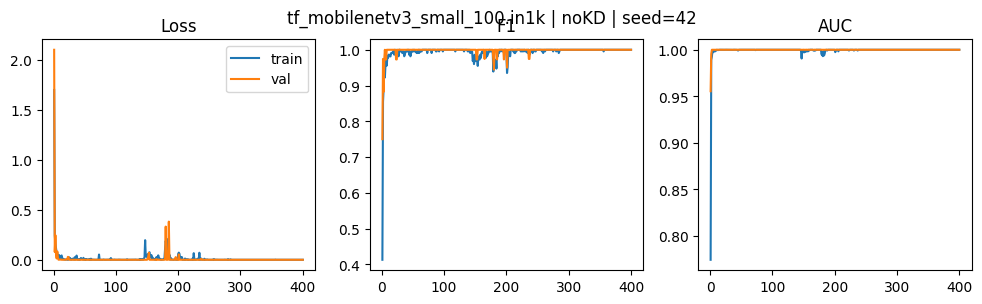

/tmp/ipykernel_863226/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.5264  F1=0.842  AUC=0.974
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[104   2]
 [  4  16]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_863226/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=5.4380 f1=0.368 auc=0.718 | val: loss=5.3242 f1=0.500 auc=0.840
[02/400] train: loss=3.1518 f1=0.443 auc=0.783 | val: loss=2.7772 f1=0.343 auc=0.712
[03/400] train: loss=2.1598 f1=0.476 auc=0.820 | val: loss=1.7429 f1=0.440 auc=0.784
[04/400] train: loss=1.6240 f1=0.579 auc=0.881 | val: loss=1.6693 f1=0.459 auc=0.751
[05/400] train: loss=1.1903 f1=0.640 auc=0.903 | val: loss=1.2785 f1=0.458 auc=0.776
[06/400] train: loss=1.1402 f1=0.652 auc=0.890 | val: loss=1.1325 f1=0.509 auc=0.855
[07/400] train: loss=1.1596 f1=0.599 auc=0.914 | val: loss=0.9428 f1=0.471 auc=0.877
[08/400] train: loss=0.8511 f1=0.629 auc=0.923 | val: loss=0.8293 f1=0.558 auc=0.861
[09/400] train: loss=0.6765 f1=0.766 auc=0.969 | val: loss=0.6945 f1=0.615 auc=0.915
[10/400] train: loss=0.7123 f1=0.724 auc=0.949 | val: loss=0.6052 f1=0.514 auc=0.884
[11/400] train: loss=0.5915 f1=0.757 auc=0.956 | val: loss=0.6250 f1=0.513 auc=0.863
[12/400] train: loss=0.5854 f1=0.749 auc=0.966 | val: loss=0.5526

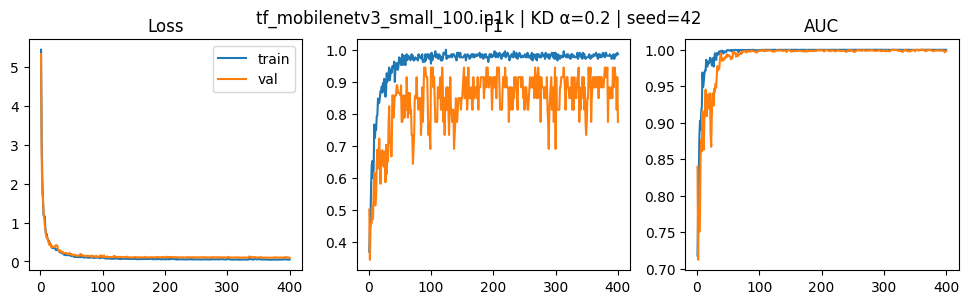

/tmp/ipykernel_863226/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1917  F1=0.821  AUC=0.937
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[103   3]
 [  4  16]]

--------------------------------------------------------------------------------
[tf_mobilenetv3_small_100.in1k] RUN 2 / 5 | seed=43
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=2.3669 f1=0.332 auc=0.674 | val: loss=1.6679 f1=0.706 auc=0.936
[02/400] train: loss=0.6501 f1=0.835 auc=0.966 | val: loss=0.2396 f1=0.878 auc=0.996
[03/400] train: loss=0.3243 f1=0.837 auc=0.985 | val: loss=0.1153 f1=0.947 auc=0.998
[04/400] train: loss=0.0993 f1=0.936 auc=0.997 | val: loss=0.4289 f1=0.944 auc=0.999
[05/400] train: loss=0.0329 f1=0.964 auc=1.000 | val: loss=0.0002 f1=1.000 auc=1.000
[06/400] train: loss=0.0954 f1=0.904 auc=0.996 | val: loss=0.0006 f1=1.000 auc=1.000
[07/400] train: loss=0.0194 f1=0.972 auc=1.000 | val: loss=0.0352 f1=0.973 a

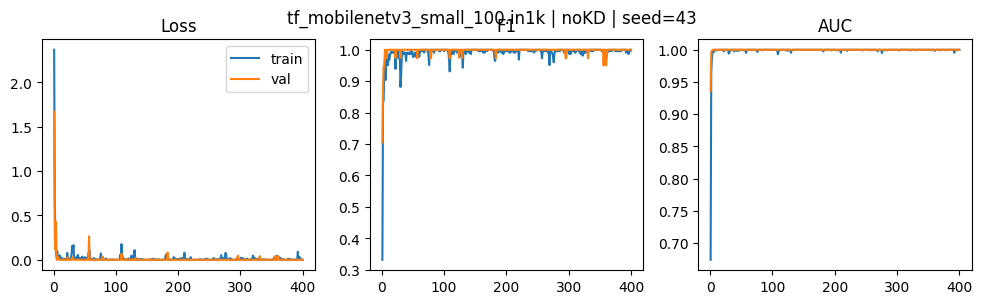

/tmp/ipykernel_863226/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.8318  F1=0.766  AUC=0.968
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[97  9]
 [ 2 18]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_863226/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=6.0075 f1=0.308 auc=0.621 | val: loss=5.0614 f1=0.509 auc=0.820
[02/400] train: loss=4.2478 f1=0.471 auc=0.806 | val: loss=3.0378 f1=0.479 auc=0.838
[03/400] train: loss=2.7194 f1=0.471 auc=0.785 | val: loss=2.6523 f1=0.493 auc=0.886
[04/400] train: loss=2.2410 f1=0.513 auc=0.860 | val: loss=1.4380 f1=0.651 auc=0.893
[05/400] train: loss=1.7449 f1=0.524 auc=0.875 | val: loss=1.4388 f1=0.588 auc=0.880
[06/400] train: loss=1.3921 f1=0.577 auc=0.883 | val: loss=1.1580 f1=0.609 auc=0.924
[07/400] train: loss=1.0461 f1=0.713 auc=0.951 | val: loss=1.1064 f1=0.640 auc=0.918
[08/400] train: loss=1.0030 f1=0.598 auc=0.920 | val: loss=0.8478 f1=0.651 auc=0.931
[09/400] train: loss=0.8450 f1=0.687 auc=0.946 | val: loss=0.8192 f1=0.629 auc=0.917
[10/400] train: loss=0.8870 f1=0.669 auc=0.925 | val: loss=0.8069 f1=0.651 auc=0.931
[11/400] train: loss=0.7613 f1=0.757 auc=0.956 | val: loss=0.9626 f1=0.560 auc=0.897
[12/400] train: loss=0.7806 f1=0.715 auc=0.938 | val: loss=0.7578

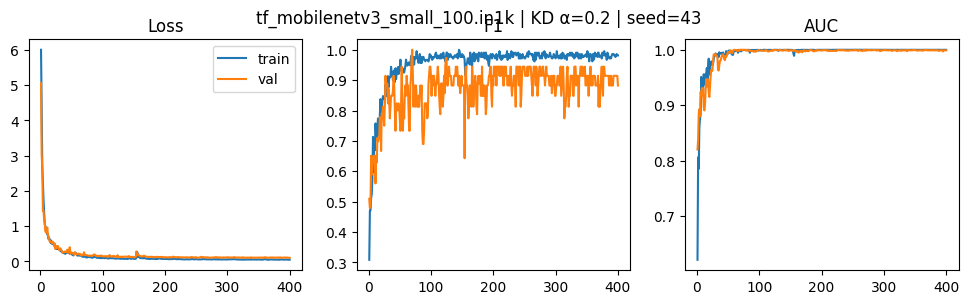

/tmp/ipykernel_863226/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.3438  F1=0.640  AUC=0.904
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[92 14]
 [ 4 16]]

--------------------------------------------------------------------------------
[tf_mobilenetv3_small_100.in1k] RUN 3 / 5 | seed=44
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=2.0075 f1=0.368 auc=0.723 | val: loss=4.0077 f1=0.261 auc=0.865
[02/400] train: loss=0.7371 f1=0.798 auc=0.961 | val: loss=0.2891 f1=0.826 auc=0.990
[03/400] train: loss=0.3158 f1=0.775 auc=0.987 | val: loss=0.0385 f1=0.974 auc=0.998
[04/400] train: loss=0.1451 f1=0.913 auc=0.996 | val: loss=0.0011 f1=1.000 auc=1.000
[05/400] train: loss=0.0132 f1=0.986 auc=1.000 | val: loss=0.0000 f1=1.000 auc=1.000
[06/400] train: loss=0.0277 f1=0.977 auc=1.000 | val: loss=0.0000 f1=1.000 auc=1.000
[07/400] train: loss=0.0437 f1=0.947 auc=1.000 | val: loss=0.0000 f1=1.000 auc=1

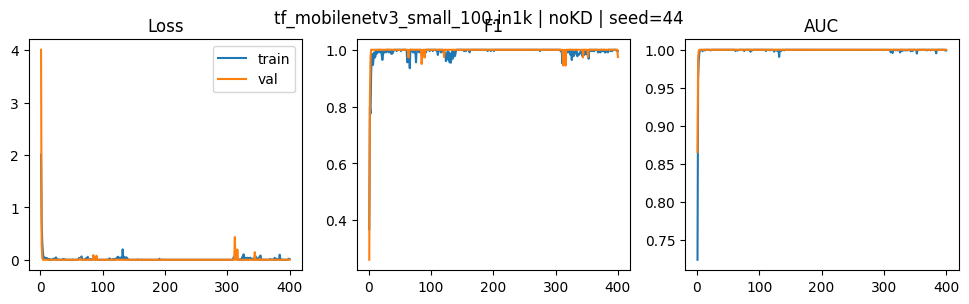

/tmp/ipykernel_863226/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.7476  F1=0.737  AUC=0.960
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[102   4]
 [  6  14]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_863226/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=6.9240 f1=0.264 auc=0.561 | val: loss=5.3463 f1=0.407 auc=0.760
[02/400] train: loss=3.7100 f1=0.468 auc=0.817 | val: loss=2.9414 f1=0.419 auc=0.780
[03/400] train: loss=2.3617 f1=0.511 auc=0.843 | val: loss=2.5096 f1=0.457 auc=0.820
[04/400] train: loss=1.8506 f1=0.576 auc=0.885 | val: loss=1.4993 f1=0.538 auc=0.798
[05/400] train: loss=1.3187 f1=0.584 auc=0.894 | val: loss=1.4320 f1=0.408 auc=0.730
[06/400] train: loss=1.1527 f1=0.541 auc=0.860 | val: loss=1.2168 f1=0.541 auc=0.778
[07/400] train: loss=1.0620 f1=0.690 auc=0.932 | val: loss=0.9734 f1=0.571 auc=0.841
[08/400] train: loss=0.8792 f1=0.680 auc=0.942 | val: loss=0.9420 f1=0.619 auc=0.842
[09/400] train: loss=0.8096 f1=0.784 auc=0.958 | val: loss=0.7942 f1=0.619 auc=0.858
[10/400] train: loss=0.7046 f1=0.757 auc=0.962 | val: loss=0.8056 f1=0.558 auc=0.801
[11/400] train: loss=0.7783 f1=0.637 auc=0.912 | val: loss=0.8629 f1=0.500 auc=0.786
[12/400] train: loss=0.6125 f1=0.721 auc=0.929 | val: loss=0.7192

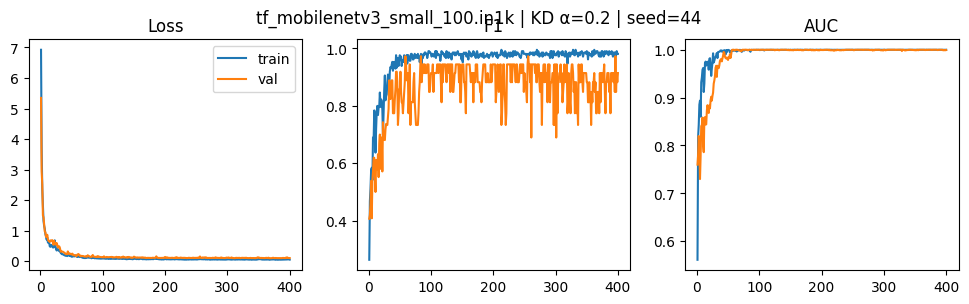

/tmp/ipykernel_863226/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.2360  F1=0.700  AUC=0.914
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[100   6]
 [  6  14]]

--------------------------------------------------------------------------------
[tf_mobilenetv3_small_100.in1k] RUN 4 / 5 | seed=45
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=1.5859 f1=0.440 auc=0.798 | val: loss=1.2480 f1=0.581 auc=0.965
[02/400] train: loss=0.6690 f1=0.762 auc=0.960 | val: loss=0.1269 f1=0.927 auc=0.996
[03/400] train: loss=0.1633 f1=0.864 auc=0.993 | val: loss=0.5450 f1=0.882 auc=0.996
[04/400] train: loss=0.1226 f1=0.942 auc=0.998 | val: loss=0.0097 f1=0.950 auc=1.000
[05/400] train: loss=0.0972 f1=0.919 auc=0.997 | val: loss=0.0004 f1=1.000 auc=1.000
[06/400] train: loss=0.0574 f1=0.956 auc=0.998 | val: loss=0.0536 f1=0.973 auc=1.000
[07/400] train: loss=0.0263 f1=0.991 auc=1.000 | val: loss=0.0006 f1=1.000 a

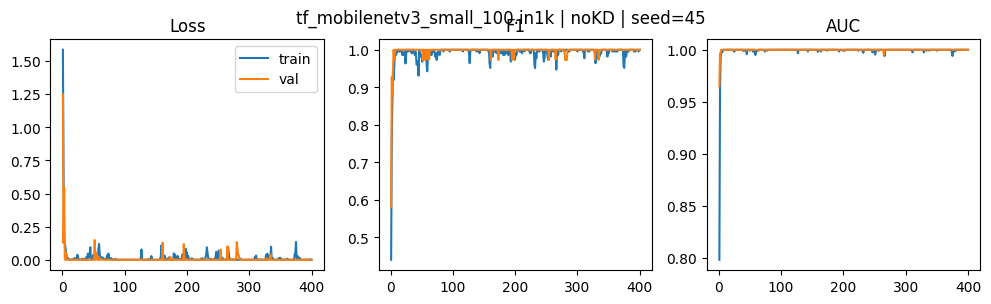

/tmp/ipykernel_863226/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.3986  F1=0.844  AUC=0.984
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[100   6]
 [  1  19]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_863226/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=5.2083 f1=0.349 auc=0.655 | val: loss=4.1490 f1=0.384 auc=0.829
[02/400] train: loss=3.4107 f1=0.487 auc=0.812 | val: loss=2.8387 f1=0.455 auc=0.809
[03/400] train: loss=2.2131 f1=0.451 auc=0.798 | val: loss=1.9222 f1=0.511 auc=0.828
[04/400] train: loss=1.4760 f1=0.587 auc=0.894 | val: loss=1.2325 f1=0.511 auc=0.876
[05/400] train: loss=1.2895 f1=0.625 auc=0.901 | val: loss=0.9457 f1=0.600 auc=0.909
[06/400] train: loss=1.0040 f1=0.677 auc=0.935 | val: loss=0.9413 f1=0.619 auc=0.923
[07/400] train: loss=0.9478 f1=0.630 auc=0.902 | val: loss=0.9810 f1=0.744 auc=0.944
[08/400] train: loss=0.8506 f1=0.715 auc=0.955 | val: loss=0.8451 f1=0.769 auc=0.936
[09/400] train: loss=0.7596 f1=0.674 auc=0.950 | val: loss=0.8100 f1=0.824 auc=0.973
[10/400] train: loss=0.7215 f1=0.760 auc=0.956 | val: loss=0.7478 f1=0.788 auc=0.968
[11/400] train: loss=0.5780 f1=0.727 auc=0.952 | val: loss=0.6041 f1=0.824 auc=0.934
[12/400] train: loss=0.6377 f1=0.669 auc=0.935 | val: loss=0.5671

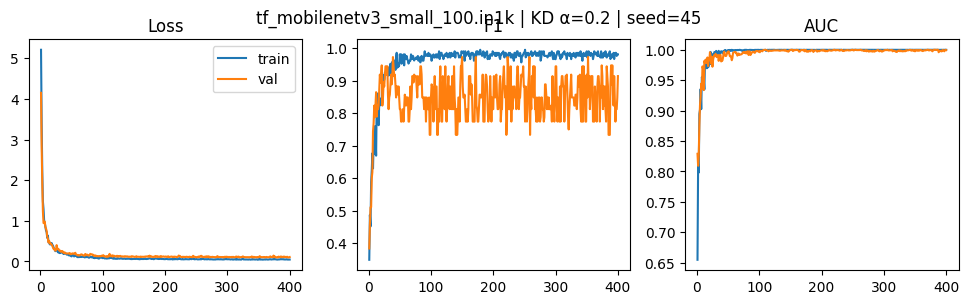

/tmp/ipykernel_863226/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1912  F1=0.800  AUC=0.975
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[99  7]
 [ 2 18]]

--------------------------------------------------------------------------------
[tf_mobilenetv3_small_100.in1k] RUN 5 / 5 | seed=46
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=3.0769 f1=0.284 auc=0.571 | val: loss=2.5048 f1=0.444 auc=0.902
[02/400] train: loss=0.7321 f1=0.730 auc=0.956 | val: loss=0.1953 f1=0.884 auc=0.990
[03/400] train: loss=0.2968 f1=0.853 auc=0.984 | val: loss=0.0940 f1=0.950 auc=0.995
[04/400] train: loss=0.0909 f1=0.930 auc=0.996 | val: loss=0.0622 f1=0.947 auc=0.999
[05/400] train: loss=0.0516 f1=0.963 auc=0.999 | val: loss=0.0026 f1=1.000 auc=1.000
[06/400] train: loss=0.0574 f1=0.943 auc=0.997 | val: loss=0.0001 f1=1.000 auc=1.000
[07/400] train: loss=0.0160 f1=0.986 auc=1.000 | val: loss=0.0006 f1=1.000 auc=1

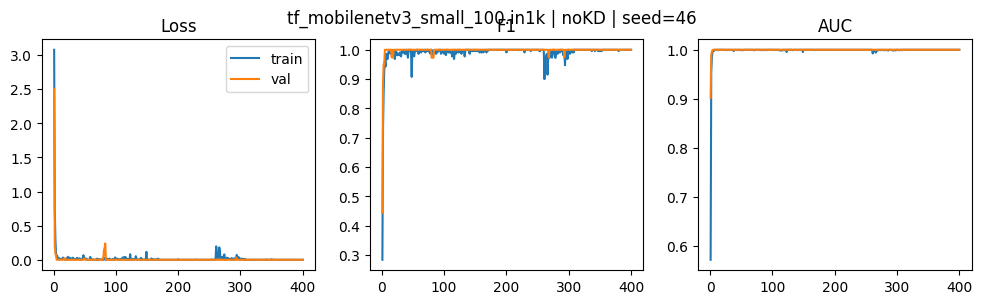

/tmp/ipykernel_863226/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.2664  F1=0.872  AUC=0.988
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[104   2]
 [  3  17]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_863226/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=6.0583 f1=0.230 auc=0.536 | val: loss=4.9175 f1=0.444 auc=0.771
[02/400] train: loss=3.7101 f1=0.481 auc=0.803 | val: loss=2.2107 f1=0.512 auc=0.775
[03/400] train: loss=1.9979 f1=0.498 auc=0.836 | val: loss=2.0105 f1=0.542 auc=0.866
[04/400] train: loss=1.6148 f1=0.584 auc=0.870 | val: loss=1.3819 f1=0.456 auc=0.796
[05/400] train: loss=1.2132 f1=0.590 auc=0.874 | val: loss=1.0992 f1=0.522 auc=0.814
[06/400] train: loss=1.0142 f1=0.667 auc=0.922 | val: loss=0.9167 f1=0.651 auc=0.869
[07/400] train: loss=0.8582 f1=0.695 auc=0.946 | val: loss=0.8165 f1=0.638 auc=0.865
[08/400] train: loss=0.8581 f1=0.623 auc=0.913 | val: loss=0.7124 f1=0.615 auc=0.890
[09/400] train: loss=0.7725 f1=0.715 auc=0.945 | val: loss=0.6853 f1=0.722 auc=0.932
[10/400] train: loss=0.8487 f1=0.694 auc=0.947 | val: loss=0.6526 f1=0.762 auc=0.949
[11/400] train: loss=0.6155 f1=0.769 auc=0.955 | val: loss=0.5502 f1=0.649 auc=0.953
[12/400] train: loss=0.5428 f1=0.736 auc=0.958 | val: loss=0.4860

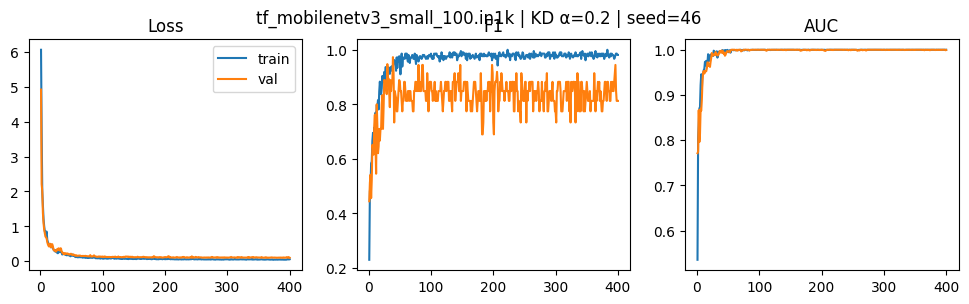

/tmp/ipykernel_863226/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.2399  F1=0.650  AUC=0.934
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[99  7]
 [ 7 13]]


,model,mode,alpha,seed,repeat_idx,best_val_auc,test_loss,test_f1,test_auc,tn,fp,fn,tp,ckpt_path
0,tf_mobilenetv3_small_100.in1k,noKD,NaN,42,0,1.000000,0.526426,0.842105,0.974292,104,2,4,16,experiments/repeats/tf_mobilenetv3_small_100_i...
1,tf_mobilenetv3_small_100.in1k,KD,0.2,42,0,0.944444,0.191744,0.820513,0.936792,103,3,4,16,experiments/repeats/tf_mobilenetv3_small_100_i...
2,tf_mobilenetv3_small_100.in1k,noKD,NaN,43,1,1.000000,0.831840,0.765957,0.967689,97,9,2,18,experiments/repeats/tf_mobilenetv3_small_100_i...
3,tf_mobilenetv3_small_100.in1k,KD,0.2,43,1,1.000000,0.343797,0.640000,0.904245,92,14,4,16,experiments/repeats/tf_mobilenetv3_small_100_i...
4,tf_mobilenetv3_small_100.in1k,noKD,NaN,44,2,1.000000,0.747575,0.736842,0.959670,102,4,6,14,experiments/repeats/tf_mobilenetv3_small_100_i...
5,tf_mobilenetv3_small_100.in1k,KD,0.2,44,2,0.972973,0.236033,0.700000,0.914151,100,6,6,14,experiments/repeats/tf_mobilenetv3_small_100_i...
6,tf_mobilenetv3_small_100.in1k,noKD,NaN,45,3,1.000000,0.398643,0.844444,0.984434,100,6,1,19,experiments/repeats/tf_mobilenetv3_small_100_i...
7,tf_mobilenetv3_small_100.in1k,KD,0.2,45,3,0.972973,0.191238,0.800000,0.975000,99,7,2,18,experiments/repeats/tf_mobilenetv3_small_100_i...
8,tf_mobilenetv3_small_100.in1k,noKD,NaN,46,4,1.000000,0.266429,0.871795,0.987736,104,2,3,17,experiments/repeats/tf_mobilenetv3_small_100_i...
9,tf_mobilenetv3_small_100.in1k,KD,0.2,46,4,0.972973,0.239920,0.650000,0.934434,99,7,7,13,experiments/repeats/tf_mobilenetv3_small_100_i...


test_f1            test_auc  \
                                              mean       std      mean   
model                         mode alpha                                 
tf_mobilenetv3_small_100.in1k KD   0.2    0.722103  0.083936  0.932925   
                              noKD NaN    0.812229  0.057669  0.974764   

                                                   best_val_auc            \
                                               std         mean       std   
model                         mode alpha                                    
tf_mobilenetv3_small_100.in1k KD   0.2    0.027215     0.972673  0.019646   
                              noKD NaN    0.011618     1.000000  0.000000   

                                             tn             fp             fn  \
                                           mean       std mean       std mean   
model                         mode alpha                                        
tf_mobilenetv3_small_100.in1k KD   0.2     98.6  4.037326  7.4  4.037326  4.6   
                              noKD NaN    101.4  2.966479  4.6  2.966479  3.2   

                                                      tp            
                                               std  mean       std  
model                         mode alpha                            
tf_mobilenetv3_small_100.in1k KD   0.2    1.949359  15.4  1.949359  
                              noKD NaN    1.923538  16.8  1.923538

In [41]:
# student_candidates = [
#     ("tf_efficientnet_lite0.in1k",        224, 64),
#     ("tf_efficientnet_lite2.in1k",        260, 48),
#     ("tf_mobilenetv3_small_100.in1k",     224, 96),
#     ("tf_mobilenetv3_large_100.in1k",     224, 64),
#     ("mobilenetv3_large_100.ra_in1k",     224, 64),
# ]

BEST_ALPHA_PER_STUDENT = {
    "tf_mobilenetv3_large_100.in1k": 0.2,
    "tf_efficientnet_lite0.in1k": 0.2,
    "tf_efficientnet_lite2.in1k": 0.2,
    "tf_mobilenetv3_small_100.in1k": 0.2,
    "mobilenetv3_large_100.ra_in1k": 0.2
}

RUN_SEEDS = [42, 43, 44, 45, 46]

def make_loaders_for_student(student_name: str, img_sz: int, bs: int):
    full_rows = splits["train"] + splits["val"]

    train_tf_full, val_tf_full = build_transforms(img_sz, cfg.robust_aug)

    ds_full = RowsDataset(full_rows, train_tf_full)
    dl_full = DataLoader(
        ds_full,
        batch_size=bs,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=True
    )

    ds_val_student = RowsDataset(splits["val"], val_tf_full)
    val_dl_student = DataLoader(
        ds_val_student,
        batch_size=bs,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True
    )

    test_tf_student = T.Compose([
        T.Resize((img_sz, img_sz)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    test_ds_student = CSVDataset(cfg.test_csv, transform=test_tf_student)
    test_dl_student = DataLoader(
        test_ds_student,
        batch_size=bs,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True
    )

    return dl_full, val_dl_student, test_dl_student

def make_cfg_for_run(base_cfg: TrainConfig,
                     student_name: str,
                     out_dir: str,
                     img_sz: int,
                     bs: int,
                     use_distill: bool,
                     alpha: float,
                     seed: int):
    return TrainConfig(
        train_csv            = base_cfg.train_csv,
        val_csv              = base_cfg.val_csv,
        test_csv             = base_cfg.test_csv,
        img_size             = img_sz,
        robust_aug           = base_cfg.robust_aug,
        batch_size           = bs,
        num_workers          = base_cfg.num_workers,
        use_class_weight     = True,
        use_weighted_sampler = False,
        epochs               = base_cfg.epochs,
        lr                   = base_cfg.lr,
        weight_decay         = base_cfg.weight_decay,
        early_stop_patience  = base_cfg.early_stop_patience,
        seed                 = seed,
        amp                  = base_cfg.amp,
        model_name           = student_name,
        num_classes          = base_cfg.num_classes,
        use_distill          = use_distill,
        teacher_ckpt         = base_cfg.teacher_ckpt,
        distill_alpha        = alpha,
        distill_T            = base_cfg.distill_T,
        out_dir              = out_dir,
        save_best_name       = "best_student.pt",
    )

all_results = []

for (student_name, img_sz, bs) in student_candidates:
    print("\n" + "#"*90)
    print("STUDENT:", student_name, "| img_sz:", img_sz, "| batch_size:", bs)
    print("#"*90)

    dl_full, val_dl_student, test_dl_student = make_loaders_for_student(student_name, img_sz, bs)

    alpha_best = BEST_ALPHA_PER_STUDENT.get(student_name, cfg.distill_alpha)

    for rep_idx, seed in enumerate(RUN_SEEDS):
        print("\n" + "-"*80)
        print(f"[{student_name}] RUN {rep_idx+1} / {len(RUN_SEEDS)} | seed={seed}")
        print("-"*80)

        out_dir_no_kd = os.path.join(
            "experiments",
            "repeats",
            student_name.replace(".", "_"),
            f"noKD",
            f"seed_{seed}"
        )
        cfg_no_kd = make_cfg_for_run(
            cfg,
            student_name=student_name,
            out_dir=out_dir_no_kd,
            img_sz=img_sz,
            bs=bs,
            use_distill=False,
            alpha=alpha_best,
            seed=seed,
        )

        best_ckpt_no_kd, best_val_auc_no_kd = train_model_with_loaders(
            cfg_no_kd, dl_full, val_dl_student,
            verbose=1,
            log_csv=True
        )

        plot_run_curves(cfg_no_kd.out_dir,
                        title=f"{student_name} | noKD | seed={seed}")

        test_loss, test_f1, test_auc, cm = quick_test_eval(
            best_ckpt_no_kd,
            cfg_no_kd.model_name,
            test_dl_student
        )

        all_results.append({
            "model": student_name,
            "mode": "noKD",
            "alpha": None,
            "seed": seed,
            "repeat_idx": rep_idx,
            "best_val_auc": best_val_auc_no_kd,
            "test_loss": test_loss,
            "test_f1": test_f1,
            "test_auc": test_auc,
            "tn": int(cm[0,0]),
            "fp": int(cm[0,1]),
            "fn": int(cm[1,0]),
            "tp": int(cm[1,1]),
            "ckpt_path": best_ckpt_no_kd,
        })

        out_dir_kd = os.path.join(
            "experiments",
            "repeats",
            student_name.replace(".", "_"),
            f"KD_alpha{str(alpha_best).replace('.','_')}",
            f"seed_{seed}"
        )

        cfg_kd = make_cfg_for_run(
            cfg,
            student_name=student_name,
            out_dir=out_dir_kd,
            img_sz=img_sz,
            bs=bs,
            use_distill=True,
            alpha=alpha_best,
            seed=seed,
        )

        best_ckpt_kd, best_val_auc_kd = train_model_with_loaders(
            cfg_kd, dl_full, val_dl_student,
            verbose=1,
            log_csv=True
        )

        plot_run_curves(cfg_kd.out_dir,
                        title=f"{student_name} | KD α={alpha_best} | seed={seed}")

        test_loss, test_f1, test_auc, cm = quick_test_eval(
            best_ckpt_kd,
            cfg_kd.model_name,
            test_dl_student
        )

        all_results.append({
            "model": student_name,
            "mode": "KD",
            "alpha": float(alpha_best),
            "seed": seed,
            "repeat_idx": rep_idx,
            "best_val_auc": best_val_auc_kd,
            "test_loss": test_loss,
            "test_f1": test_f1,
            "test_auc": test_auc,
            "tn": int(cm[0,0]),
            "fp": int(cm[0,1]),
            "fn": int(cm[1,0]),
            "tp": int(cm[1,1]),
            "ckpt_path": best_ckpt_kd,
        })

os.makedirs("experiments/summary", exist_ok=True)
df_results = pd.DataFrame(all_results)
df_results.to_csv("experiments/summary/repeats_results.csv", index=False)
display(df_results)

summary = (
    df_results
    .groupby(["model","mode","alpha"], dropna=False)[["test_f1","test_auc","best_val_auc","tn","fp","fn","tp"]]
    .agg(["mean","std"])
)
display(summary)


In [42]:
summary = (
    df_results
    .groupby(["model","mode","alpha"], dropna=False)[["test_f1","test_auc","test_loss"]]
    .agg(["mean","std"])
)
display(summary)

test_f1            test_auc  \
                                              mean       std      mean   
model                         mode alpha                                 
tf_mobilenetv3_small_100.in1k KD   0.2    0.722103  0.083936  0.932925   
                              noKD NaN    0.812229  0.057669  0.974764   

                                                   test_loss            
                                               std      mean       std  
model                         mode alpha                                
tf_mobilenetv3_small_100.in1k KD   0.2    0.027215  0.240547  0.062238  
                              noKD NaN    0.011618  0.554183  0.235722

In [43]:
def plot_run_curves(run_dir, title=None):
    csv_path = os.path.join(run_dir, "train_log.csv")
    if not os.path.exists(csv_path):
        print("missing:", csv_path); return
    df = pd.read_csv(csv_path)
    fig,ax = plt.subplots(1,3,figsize=(12,3))
    ax[0].plot(df.epoch, df.tr_loss, label="train"); ax[0].plot(df.epoch, df.va_loss, label="val")
    ax[0].set_title("Loss"); ax[0].legend()
    ax[1].plot(df.epoch, df.tr_f1, label="train"); ax[1].plot(df.epoch, df.va_f1, label="val")
    ax[1].set_title("F1")
    ax[2].plot(df.epoch, df.tr_auc, label="train"); ax[2].plot(df.epoch, df.va_auc, label="val")
    ax[2].set_title("AUC")
    if title: fig.suptitle(title)
    plt.show()

In [44]:
plt.figure(figsize=(7,4))
plt.bar(df_summary["model"], df_summary["mean_auc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean AUC (CV)")
plt.title("CV Mean AUC by Candidate")
plt.tight_layout(); plt.show()

NameError: name 'df_summary' is not defined

<Figure size 700x400 with 0 Axes>

In [ ]:
models = sorted(df_perfold["model"].unique())
data = [df_perfold[df_perfold["model"]==m]["val_auc"].values for m in models]

plt.figure(figsize=(7,4))
plt.boxplot(data, labels=models, showmeans=True)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Val AUC"); plt.title("Per-fold AUC distribution")
plt.tight_layout(); plt.show()

In [ ]:
import os
print(cfg_final.out_dir)
log_path = os.path.join(cfg_final.out_dir, "train_log.csv")
if os.path.exists(log_path):
    logdf = pd.read_csv(log_path)
    plt.figure(figsize=(6,4))
    plt.plot(logdf["epoch"], logdf["tr_auc"], label="train AUC")
    plt.plot(logdf["epoch"], logdf["va_auc"], label="val AUC")
    plt.xlabel("epoch"); plt.ylabel("AUC"); plt.title("Training curve (final)")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(logdf["epoch"], logdf["tr_f1"], label="train F1")
    plt.plot(logdf["epoch"], logdf["va_f1"], label="val F1")
    plt.xlabel("epoch"); plt.ylabel("F1"); plt.title("Training curve (final)")
    plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc as sk_auc
import numpy as np, torch

model = create_model(cfg_final.model_name, 2).to(device)
model.load_state_dict(torch.load(best_ckpt, map_location=device)); model.eval()

y_prob, y_true = [], []
with torch.no_grad():
    for x, y in test_dl_student:
        x = x.to(device)
        p = torch.softmax(model(x), dim=1)[:,1].detach().cpu().numpy()
        y_prob.append(p); y_true.append(y.numpy())
y_prob = np.concatenate(y_prob); y_true = np.concatenate(y_true)

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = sk_auc(fpr, tpr)
plt.figure(figsize=(5,4)); plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
plt.legend(); plt.tight_layout(); plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_true, y_prob)
pr_auc = sk_auc(rec, prec)
plt.figure(figsize=(5,4)); plt.plot(rec, prec, label=f"PR AUC={pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (test)")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
def collect_probs_labels(ckpt_path, arch_name, dataloader):
    model = create_model(arch_name, 2).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()
    probs=[]; labels=[]
    with torch.no_grad():
        for x,y in dataloader:
            x = x.to(device); 
            p = torch.softmax(model(x), dim=1)[:,1].detach().cpu().numpy()
            probs.append(p); labels.append(y.numpy())
    return np.concatenate(probs), np.concatenate(labels)

In [ ]:
def plot_roc_pr(y_true, y_prob, title=""):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = sk_auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = np.trapz(prec, rec)

    fig = plt.figure(figsize=(11,4))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
    plt.title(f"ROC AUC = {roc_auc:.3f}"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.subplot(1,2,2)
    plt.plot(rec, prec)
    plt.title(f"PR curve (area ≈ {pr_auc:.3f})"); plt.xlabel("Recall"); plt.ylabel("Precision")
    fig.suptitle(title)
    plt.show()

In [ ]:
def find_best_f1_threshold(y_true, y_prob):
    thr_list = np.linspace(0.05, 0.95, 37)
    best = (0.5, -1.0)
    for thr in thr_list:
        f1 = f1_score(y_true, (y_prob>=thr).astype(int))
        if f1 > best[1]: best = (thr, f1)
    return best

In [ ]:
def show_confusion(y_true, y_prob, thr=0.5, title=""):
    y_hat = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_hat, labels=[0,1])
    fig = plt.figure(figsize=(3,3))
    plt.imshow(cm, cmap="Blues"); plt.title(title)
    plt.xticks([0,1],["Pred Safe","Pred Viol"]); plt.yticks([0,1],["True Safe","True Viol"])
    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(cm[i,j]), ha='center', va='center')
    plt.show()
    return cm

In [ ]:
teacher_arch = "tf_efficientnetv2_l"
teacher_ckpt = "models/server/best_server.pt"
yprob_te, ytrue_te = collect_probs_labels(teacher_ckpt, teacher_arch, test_dl)
plot_roc_pr(ytrue_te, yprob_te, title="TEACHER")
thr_te, bestf1_te = find_best_f1_threshold(ytrue_te, yprob_te)
print("Teacher best-F1 thr:", round(thr_te,2), "F1=", round(bestf1_te,3))
_ = show_confusion(ytrue_te, yprob_te, thr=0.5, title="Teacher CM @0.5")
_ = show_confusion(ytrue_te, yprob_te, thr=thr_te, title=f"Teacher CM @thr={thr_te:.2f}")

In [ ]:
best_student_arch = cfg_final.model_name
best_student_ckpt = best_ckpt
print("Best student:", best_student_arch)
print("Checkpoint path:", best_student_ckpt)

In [ ]:
yprob_st, ytrue_st = collect_probs_labels(best_student_ckpt, best_student_arch, test_dl_student) 
plot_roc_pr(ytrue_st, yprob_st, title=f"STUDENT: {best_student_arch}")
thr_st, bestf1_st = find_best_f1_threshold(ytrue_st, yprob_st)
print("Student best-F1 thr:", round(thr_st,2), "F1=", round(bestf1_st,3))
_ = show_confusion(ytrue_st, yprob_st, thr=0.5, title="Student CM @0.5")
_ = show_confusion(ytrue_st, yprob_st, thr=thr_st, title=f"Student CM @thr={thr_st:.2f}")

plot_roc_pr(ytrue_st, yprob_st, title=f"STUDENT: {best_student_arch}")
thr_st, bestf1_st = find_best_f1_threshold(ytrue_st, yprob_st)
print("Student best-F1 thr:", round(thr_st,2), "F1=", round(bestf1_st,3))
_ = show_confusion(ytrue_st, yprob_st, thr=0.5, title="Student CM @0.5")
_ = show_confusion(ytrue_st, yprob_st, thr=thr_st, title=f"Student CM @thr={thr_st:.2f}")

In [ ]:
df = score_kd.copy()
fig=plt.figure(figsize=(6,4))
plt.scatter(df["test_auc"], df["latency_ms_1x"])
for _,r in df.iterrows():
    plt.annotate(r["model"], (r["test_auc"], r["latency_ms_1x"]), fontsize=8, xytext=(2,2), textcoords="offset points")
plt.xlabel("Test AUC (higher better)")
plt.ylabel("Latency per image (ms, lower better)")
plt.title("Accuracy vs Latency (students)")
plt.grid(True, ls="--", alpha=.4)
plt.show()

In [ ]:
# ARCH_STUDENT = "tf_efficientnet_lite2" 
# NUM_CLASSES  = 2
# IMG_SIZE     = 224

# CKPT_STUDENT = "models/client/best_student.pt"
# EXPORT_DIR   = "export_tflite"
# LABELS_TXT   = f"{EXPORT_DIR}/labels.txt"

# DATA_TRAIN_DIR = "data/train"


In [ ]:
# !pip install -q onnx onnxsim onnx-tf

# import os, io, random, numpy as np
# import torch, timm
# from PIL import Image

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model_student = timm.create_model(
#     ARCH_STUDENT, pretrained=False, num_classes=NUM_CLASSES
# ).to(device)

# sd = torch.load(CKPT_STUDENT, map_location=device)
# state_dict = sd.get("state_dict", sd.get("model", sd))
# if state_dict is None:
#     state_dict = sd
# model_student.load_state_dict(state_dict, strict=True)
# model_student.eval()

# print("Loaded:", ARCH_STUDENT, "classes:", NUM_CLASSES)

In [ ]:
# os.makedirs(EXPORT_DIR, exist_ok=True)
# ONNX_RAW = f"{EXPORT_DIR}/student_raw.onnx"
# ONNX_SIM = f"{EXPORT_DIR}/student_sim.onnx"

# dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=device)

# torch.onnx.export(
#     model_student, dummy, ONNX_RAW,
#     input_names=["input"], output_names=["logits"],
#     opset_version=13, do_constant_folding=True, dynamic_axes=None
# )

# print("ONNX saved:", ONNX_RAW)

In [ ]:
# import onnx
# from onnxsim import simplify

# model_onnx = onnx.load(ONNX_RAW)
# model_simplified, check = simplify(model_onnx)
# assert check, "Simplified ONNX model could not be validated"
# onnx.save(model_simplified, ONNX_SIM)
# print("ONNX simplified saved:", ONNX_SIM)

In [ ]:
# from onnx_tf.backend import prepare

# model_onnx = onnx.load(ONNX_SIM)
# tf_rep = prepare(model_onnx)  # konversi ke representasi TF
# TF_SAVED_DIR = f"{EXPORT_DIR}/tf_saved"
# if os.path.exists(TF_SAVED_DIR):
#     import shutil; shutil.rmtree(TF_SAVED_DIR)

# tf_rep.export_graph(TF_SAVED_DIR)
# print("TF SavedModel:", TF_SAVED_DIR)

In [ ]:
# import tensorflow as tf
# import pathlib, itertools

# TFL_FP32 = f"{EXPORT_DIR}/student_fp32.tflite"
# TFL_FP16 = f"{EXPORT_DIR}/student_fp16.tflite"
# TFL_INT8 = f"{EXPORT_DIR}/student_int8.tflite"

# # FP32 (baseline)
# conv = tf.lite.TFLiteConverter.from_saved_model(TF_SAVED_DIR)
# tfl32 = conv.convert()
# open(TFL_FP32, "wb").write(tfl32)

# # FP16 (disarankan: kecil, cepat, akurasi hampir sama)
# conv = tf.lite.TFLiteConverter.from_saved_model(TF_SAVED_DIR)
# conv.optimizations = [tf.lite.Optimize.DEFAULT]
# conv.target_spec.supported_types = [tf.float16]
# tfl16 = conv.convert()
# open(TFL_FP16, "wb").write(tfl16)

# # INT8 (paling kecil; butuh representative dataset)
# # Kita sampling beberapa gambar dari train_dir, lakukan preprocessing ImageNet (sesuai training)
# def representative_dataset_gen(folder=DATA_TRAIN_DIR, samples=100):
#     import os, random
#     from PIL import Image
#     paths = []
#     for cls in os.listdir(folder):
#         cpath = os.path.join(folder, cls)
#         if os.path.isdir(cpath):
#             for p in os.listdir(cpath):
#                 if p.lower().endswith((".jpg",".jpeg",".png")):
#                     paths.append(os.path.join(cpath, p))
#     random.shuffle(paths)
#     paths = paths[:samples]

#     mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)[None,None,:]
#     std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)[None,None,:]

#     for p in paths:
#         img = Image.open(p).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
#         x = np.array(img, dtype=np.float32) / 255.0
#         x = (x - mean) / std
#         x = np.expand_dims(x, axis=0)  # [1,H,W,3] karena TF SavedModel biasanya NHWC
#         # Beberapa converter expect NCHW; jika perlu, transpose ke NCHW:
#         # x = np.transpose(x, (0,3,1,2))
#         yield [x]

# try:
#     conv = tf.lite.TFLiteConverter.from_saved_model(TF_SAVED_DIR)
#     conv.optimizations = [tf.lite.Optimize.DEFAULT]
#     conv.representative_dataset = lambda: representative_dataset_gen(DATA_TRAIN_DIR, 100)
#     # Mode int8 “full integer” jika memungkinkan:
#     conv.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#     # Tipe input/output (bisa uint8 atau int8 tergantung preferensi):
#     conv.inference_input_type = tf.float32  # sering lebih aman; biarkan float32 supaya preprocessing tetap float
#     conv.inference_output_type = tf.float32
#     tfl8 = conv.convert()
#     open(TFL_INT8, "wb").write(tfl8)
#     print("INT8 TFLite created.")
# except Exception as e:
#     print("INT8 conversion skipped due to:", e)

# print("TFLite ready:", TFL_FP32, TFL_FP16, "(and possibly)", TFL_INT8)

In [ ]:
# # Ambil satu gambar uji
# TEST_IMG = "data/val/violence/xxx.jpg"   # ganti satu file nyata

# # Preprocess (PyTorch)
# def preprocess_pt(pil):
#     x = np.array(pil.resize((IMG_SIZE, IMG_SIZE)), dtype=np.float32)/255.0
#     x = (x - np.array([0.485,0.456,0.406])) / np.array([0.229,0.224,0.225])
#     x = np.transpose(x, (2,0,1))  # CHW
#     x = torch.from_numpy(x).unsqueeze(0).to(device)
#     return x

# # Preprocess (TF/TFLite) NHWC
# def preprocess_tf(pil):
#     x = np.array(pil.resize((IMG_SIZE, IMG_SIZE)), dtype=np.float32)/255.0
#     x = (x - np.array([0.485,0.456,0.406])) / np.array([0.229,0.224,0.225])
#     x = np.expand_dims(x, 0)  # NHWC
#     return x

# from scipy.special import softmax
# pil = Image.open(TEST_IMG).convert("RGB")

# # PyTorch logits -> prob
# with torch.no_grad():
#     pt_in = preprocess_pt(pil)
#     pt_logits = model_student(pt_in).cpu().numpy()
#     pt_prob = softmax(pt_logits, axis=1)[0]
# print("PyTorch prob:", pt_prob)

# # TFLite (FP16) inference
# import tensorflow as tf
# interpreter = tf.lite.Interpreter(model_path=TFL_FP16)
# interpreter.allocate_tensors()
# inp = interpreter.get_input_details()[0]
# out = interpreter.get_output_details()[0]

# tf_in = preprocess_tf(pil).astype(np.float32)

# # Jika input shape butuh NCHW (jarang), transpose di sini.
# interpreter.set_tensor(inp['index'], tf_in)
# interpreter.invoke()
# tfl_logits = interpreter.get_tensor(out['index'])
# tfl_prob = softmax(tfl_logits, axis=1)[0]
# print("TFLite prob:", tfl_prob)

In [ ]:
# with open(LABELS_TXT, "w") as f:
#     f.write("safe\nviolence\n")
# print("Labels saved:", LABELS_TXT)

In [ ]:
# from PIL import Image
# import torch, numpy as np
# import torchvision.transforms as T

# @torch.inference_mode()
# def predict_image(ckpt_path: str,
#                   arch_name: str,
#                   img_path: str,
#                   img_size: int = 224,
#                   threshold: float = 0.5):

#     model = create_model(arch_name, num_classes=2, pretrained=False).to(device)
#     sd = torch.load(ckpt_path, map_location=device)
#     model.load_state_dict(sd)
#     model.eval()

#     # preprocessing (samakan dengan val_tf kamu)
#     tf = T.Compose([
#         T.Resize((img_size, img_size)),
#         T.ToTensor(),
#         T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
#     ])

#     # open image
#     img = Image.open(img_path).convert("RGB")
#     x = tf(img).unsqueeze(0).to(device)  # [1,3,H,W]

#     # forward
#     logits = model(x)
#     prob = torch.softmax(logits, dim=1)[0,1].item()  # prob kelas 1 = "Violence"
#     pred = int(prob >= threshold)

#     return {
#         "path": img_path,
#         "arch": arch_name,
#         "checkpoint": ckpt_path,
#         "img_size": img_size,
#         "prob_violence": float(prob),
#         "pred_label": pred,  # 1 = Violence, 0 = Safe
#         "threshold": threshold,
#     }

# res_teacher = predict_image(
#     ckpt_path="models/server/best_server.pt",
#     arch_name="tf_efficientnetv2_l", 
#     img_path="tes3.jpg",
#     img_size=320, 
#     threshold=0.5
# )
# print(res_teacher)

# res_student = predict_image(
#     ckpt_path="experiments/runs/student_tf_efficientnet_lite0_in1k_kd/best_student.pt",
#     arch_name="tf_efficientnet_lite0.in1k",
#     img_path="tes3.jpg",
#     img_size=224, 
#     threshold=0.5
# )
# print(res_student)
